In [14]:
try:
    GUTENBERG = True
    from gutenberg.acquire import load_etext
    from gutenberg.query import get_etexts, get_metadata
    from gutenberg.acquire import get_metadata_cache
    from gutenberg.acquire.text import UnknownDownloadUriException
    from gutenberg.cleanup import strip_headers
    from gutenberg._domain_model.exceptions import CacheAlreadyExistsException
except ImportError:
    GUTENBERG = False
    print('Gutenberg is not installed. See instructions at https://pypi.python.org/pypi/Gutenberg')
from keras.models import Input, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
import keras.callbacks
import keras.backend as K
import scipy.misc
import json

import os, sys
import re
import PIL
from PIL import ImageDraw

from keras.optimizers import RMSprop
import random
import numpy as np
import tensorflow as tf
from keras.utils import get_file

from IPython.display import clear_output, Image, display, HTML
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

In [2]:
if GUTENBERG:
    cache = get_metadata_cache()
    try:
        cache.populate()
    except CacheAlreadyExistsException:
        pass

In [3]:
if GUTENBERG:
    for text_id in get_etexts('author', 'Shakespeare, William'):
        print(text_id, list(get_metadata('title', text_id))[0])

1536 The Life of Timon of Athens
1537 Pericles, Prince of Tyre
1538 Cymbeline
39939 Kuningas Henrik Viides
1527 Twelfth Night; Or, What You Will
1539 The Winter's Tale
1540 The Tempest
1541 The Life of Henry the Eighth
1528 The History of Troilus and Cressida
1543 A Lover's Complaint
1544 The Passionate Pilgrim
1545 The Passionate Pilgrim
43532 Miten haluatte
1529 All's Well That Ends Well
1546 Sonnets on Sundry Notes of Music
17930 Le songe d'une nuit d'été
24036 Sonnet 130
1041 Shakespeare's Sonnets
7185 Othello
7186 Was ihr wollt
1530 Measure for Measure
1045 Venus and Adonis
16893 Macbeth
1531 Othello, the Moor of Venice
1124 The History of Troilus and Cressida
1532 The Tragedy of King Lear
32797 Οθέλλος
Σαικσπείρου Τραγωδίαι Μέρος Β'
22045 La festa dels reis
Lo que vulgueu (Twelfth Night)
22556 Cymbeline
44580 Loppu hyvä, kaikki hyvä
1127 The Tragedy of Othello, Moor of Venice
10281 Antony's Address over the Body of Caesar
From Julius Caesar
12842 A Fairy Tale in Two Acts Taken fr

In [4]:
if GUTENBERG:
    shakespeare = strip_headers(load_etext(100))
else:
    path = get_file('shakespeare', 'http://gutenberg.pglaf.org/1/0/100/100-0.txt')
    shakespeare = open(path).read()
training_text = shakespeare.split('\nTHE END', 1)[-1]
len(training_text)

5225350

In [5]:
chars = list(sorted(set(training_text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
len(chars)

83

In [6]:
def char_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
model = char_rnn_model(len(chars), num_layers=2, num_nodes=640, dropout=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 83)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 640)         1853440   
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 83)          53203     
Total params: 5,186,003
Trainable params: 5,186,003
Non-trainable params: 0
_________________________________________________________________


In [8]:
CHUNK_SIZE = 160

def data_generator(all_text, char_to_idx, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    y = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(all_text) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, len(char_to_idx)))
            for i in range(chunk_size + 1):
                chunk[i, char_to_idx[all_text[idx + i]]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(training_text, char_to_idx, 4, chunk_size=CHUNK_SIZE))

(array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., .

In [11]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
model.fit_generator(
    data_generator(training_text, char_to_idx, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(training_text) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/40
100s - loss: 3.2858 - acc: 0.2282
Epoch 2/40
100s - loss: 3.2915 - acc: 0.2181
Epoch 3/40
102s - loss: 1.9426 - acc: 0.4542
Epoch 4/40
102s - loss: 1.2815 - acc: 0.6139
Epoch 5/40
102s - loss: 1.2152 - acc: 0.6357
Epoch 6/40
102s - loss: 1.1496 - acc: 0.6505
Epoch 7/40
102s - loss: 1.1289 - acc: 0.6582
Epoch 8/40
102s - loss: 1.0944 - acc: 0.6662
Epoch 9/40
102s - loss: 1.0725 - acc: 0.6718
Epoch 10/40
102s - loss: 1.0551 - acc: 0.6773
Epoch 11/40
102s - loss: 1.0478 - acc: 0.6802
Epoch 12/40
102s - loss: 1.0200 - acc: 0.6855
Epoch 13/40
102s - loss: 1.0303 - acc: 0.6869
Epoch 14/40
102s - loss: 0.9999 - acc: 0.6917
Epoch 15/40
102s - loss: 0.9895 - acc: 0.6944
Epoch 16/40
102s - loss: 1.0104 - acc: 0.6943
Epoch 17/40
102s - loss: 0.9822 - acc: 0.6981
Epoch 18/40
102s - loss: 0.9703 - acc: 0.7011
Epoch 19/40
102s - loss: 0.9814 - acc: 0.7019


In [16]:
with open('zoo/06/shakespeare.json', 'w') as fout:
    json.dump({
        'chars': ''.join(chars),
        'char_to_idx': char_to_idx,
        'chunk_size': CHUNK_SIZE,
    }, fout)
model.save('zoo/06/shakespeare.h5')

In [12]:
def generate_output(model, training_text, start_index=None, diversity=None, amount=400):
    if start_index is None:
        start_index = random.randint(0, len(training_text) - CHUNK_SIZE - 1)
    generated = training_text[start_index: start_index + CHUNK_SIZE]
    yield generated + '#'
    for i in range(amount):
        x = np.zeros((1, len(generated), len(chars)))
        for t, char in enumerate(generated):
            x[0, t, char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)     
        next_char = chars[next_index]
        yield next_char

        generated += next_char
    return generated

for ch in generate_output(model, training_text):
    sys.stdout.write(ch)
print()
        

 heaven is hid,
    Behind the globe, that lights the lower world,
    Then thieves and robbers range abroad unseen
    In murders and in outrage boldly here;
 #   And then the world is still the world,
    The woman's that was still and the worst
    That they were strange and stol'n the fiery steeds,
    The seasons of the world, and then they were,
    And then they would have made them dead,
    And then they have deserv'd the charges,
    The state of the world, when they are stronger,
    The strongest of the common wreck,
    The which in the world


In [4]:
def find_python(rootdir):
    matches = []
    for root, dirnames, filenames in os.walk(rootdir):
        for fn in filenames:
            if fn.endswith('.py'):
                matches.append(os.path.join(root, fn))

    return matches
#  + find_python(os.path.join(sys.executable.rsplit('/', 2)[0], 'lib'))
srcs = find_python(random.__file__.rsplit('/', 1)[0])
len(srcs)

1504

In [5]:
def replacer(value):
    value = ''.join(ch for ch in value if ord(ch) < 127)
    if not ' ' in value:
        return value
    if sum(1 for ch in value if ch.isalpha()) > 6:
        return 'MSG'
    return value


def replace_literals(st):
    res = []
    start_text = start_quote = i = 0
    quote = ''
    while i < len(st):
        if quote:
            if st[i: i + len(quote)] == quote:
                quote = ''
                start_text = i
                res.append(replacer(st[start_quote: i]))
        elif st[i] in '"\'':
            quote = st[i]
            if i < len(st) - 2 and st[i + 1] == st[i + 2] == quote:
                quote = 3 * quote
            start_quote = i + len(quote)
            res.append(st[start_text: start_quote])
        if st[i] == '\n' and len(quote) == 1:
            start_text = i
            res.append(quote)
            quote = ''
        if st[i] == '\\':
            i += 1
        i += 1
    return ''.join(res) + st[start_text:]

#replace_literals('print("hel\\"lo")') + replace_literals("print('hel\\'lo world')")
replace_literals('this = "wrong\n')

'this = ""\n'

In [8]:
COMMENT_RE = re.compile('#.*')
python_code = []
for fn in srcs:
    try:
        with open(fn, 'r') as fin:
            src = fin.read()
    except UnicodeDecodeError:
        print('Could not read %s' % fn)
    src = replace_literals(src)
    src = COMMENT_RE.sub('', src)
    python_code.append(src)

python_code = '\n\n\n'.join(python_code)
len(python_code)

Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/dbapi.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/factory.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/hooks.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/regression.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/transactions.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/types.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/sqlite3/test/userfunctions.py
Could not read /usr/local/Cellar/python3/3.5.2/Frameworks/Python.framework/Versions/3.5/lib/python3.5/test/bad

16775961

In [9]:
py_chars = list(sorted(set(python_code)))
py_char_to_idx = {ch: idx for idx, ch in enumerate(py_chars)}
len(py_chars)

111

In [10]:
py_model = char_rnn_model(len(py_chars), num_layers=2, num_nodes=640, dropout=0)
py_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 111)         0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 640)         1925120   
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 111)         71151     
Total params: 5,275,631
Trainable params: 5,275,631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
py_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) / (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40


In [53]:
def generate_code(model, start_with='\ndef ', end_with='\n\n', diversity=1.0):
    generated = start_with
    yield generated
    for i in range(2000):
        x = np.zeros((1, len(generated), len(py_chars)))
        for t, char in enumerate(generated):
            x[0, t, py_char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        
        preds = np.asarray(preds[len(generated) - 1]).astype('float64')
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        next_index = np.argmax(probas)        
        next_char = py_chars[next_index]
        yield next_char

        generated += next_char
        if generated.endswith(end_with):
            break

for i in range(20):
    for ch in generate_code(py_model):
        sys.stdout.write(ch)
        st += ch
    print()



def set_surrounding_binput(name):
    """MSG"""
    
    
    pat = path.join(supersion, name)
    if not result:
        return path



def _calculate_ratio(val):
    """MSG"""
    if value and value[0] != '0':
        raise errors.HeaderParseError(
            "MSG".format(Storable))
    return value



def _get_uid(filename):
    """MSG"""
    
    filename = getattr(file, "func", None)
    if isinstance(filename, bytes):
        return file, finfo
    return objects



def isfirstline(exc_info):
    """MSG"""
    
    
    if 'N' in os.environ:
            return 'xba'
        key, val = os.environ['CC']
    elif context is None:
        content_type = token.COMMA + self.childNevent
        self.type, self._default = default_value
        self.names = parser.Get(
                type(self).__new__,
    _type_var, __main__.__dict__ = metacles and self._args_magic_methods(self.get_saved(): final_or(yey, message))



def is_nan(o):
    """MSG"""
    word = "*"
    if not p.startswith

/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


(n, n80)
    q += 4
    year = i+1   
    
    
    endres[p] = 1
    i = 2. 
    whence = 2 * c
    assert 1 <= magic <= 200
    if len(match.end() > 1:
        print(f.active())
        firstline = finder.find(ladespec, linespace, linestarts, strict=name)
        if cache[name] == len(spec):
            log.warn("MSG",
                  parent=spec)
    extractargmsg = "MSG"
    return units_fd, etabs_pattern(s)



def Queue():
    """MSG"""
    return sum(thing, NamespaceLoader, _AsyncDeprecawatingFileHandler)



def version(deltas[func]):
    return UUID(dicts.pop(int.defaultdict(value)))



def decode_long(old, new, allow_dot):
    yearef = deepcopy(parent)
    def display_name(self, newpath):
        "MSG"
        return normp.fp
        return (not self.encoder or encoding)



def quopri_default_https_config():
    global environment_ew = SubprocessClass
    if fromdir:
        print(foll(format, method)
    else:
        try:
            key = fp.readline().split(',')
        e

In [11]:
BATCH_SIZE = 512

flat_model = char_rnn_model(len(py_chars), num_layers=1, num_nodes=512, dropout=0)

early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

flat_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) / (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
46s - loss: 3.3759 - acc: 0.3166
Epoch 2/40
46s - loss: 3.2798 - acc: 0.3217
Epoch 3/40
47s - loss: 3.2740 - acc: 0.3218
Epoch 4/40
47s - loss: 3.1735 - acc: 0.3228
Epoch 5/40
47s - loss: 2.6554 - acc: 0.3680
Epoch 6/40
47s - loss: 2.4541 - acc: 0.4057
Epoch 7/40
47s - loss: 2.4880 - acc: 0.4077
Epoch 8/40
47s - loss: 2.5079 - acc: 0.4135
Epoch 9/40
47s - loss: 2.1347 - acc: 0.4897
Epoch 10/40
47s - loss: 1.3656 - acc: 0.6583
Epoch 11/40
47s - loss: 1.0606 - acc: 0.7310
Epoch 12/40
47s - loss: 0.9297 - acc: 0.7616
Epoch 13/40
47s - loss: 0.8886 - acc: 0.7762
Epoch 14/40
47s - loss: 0.8443 - acc: 0.7875
Epoch 15/40
47s - loss: 0.7958 - acc: 0.7970
Epoch 16/40
47s - loss: 0.8021 - acc: 0.8000
Epoch 17/40
47s - loss: 0.7856 - acc: 0.8039
Epoch 18/40
47s - loss: 0.7752 - acc: 0.8072
Epoch 19/40
47s - loss: 0.7776 - acc: 0.8085


In [ ]:
example_code = 'if a == 2:\n    b=1\nelse:\n    b=2\n'
#example_code = 'a=(2 * 3)\nb=(4 * 6 + 7)\nreturn C'

def activations(model, code):
    x = np.zeros((1, len(code), len(py_char_to_idx)))
    for t, char in enumerate(code):
        x[0, t, py_char_to_idx[char]] = 1.
    output = model.get_layer('lstm_layer_1').output
    f = K.function([model.input], [output])
    return f([x])[0][0]

act = activations(flat_model, example_code)
act.shape

In [83]:
def interesting_neurons(act):
    res = []
    for n in np.argmax(act, axis=1):
        if not n in res:
            res.append(n)
    return res

neurons = interesting_neurons(act)
len(neurons)

22

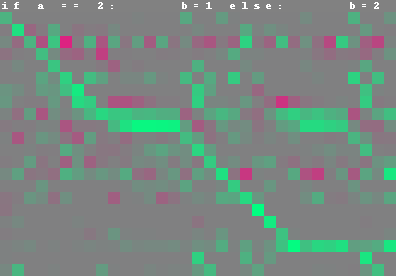

In [84]:
def visualize_neurons(neurons, code, act, cell_size=12):
    img = np.full((len(neurons) + 1, len(code), 3), 128)
    scores = (act[:, neurons].T + 1) / 2
    img[1:, :, 0] = 255 * (1 - scores)
    img[1:, :, 1] = 255 * scores

    f = BytesIO()
    img = scipy.misc.imresize(img, float(cell_size), interp='nearest')
    pil_img = PIL.Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)
    for idx, ch in enumerate(code):
        draw.text((idx * cell_size + 2, 0), ch)
    pil_img.save(f, 'png')
    return Image(data=f.getvalue())

img = visualize_neurons(neurons, example_code, act)
display(img)

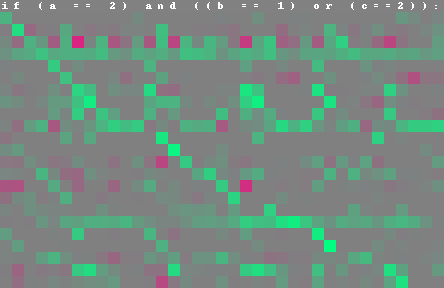

In [55]:
def image_for_code(code):
    act = activations(flat_model, code)
    neurons = interesting_neurons(act)
    return visualize_neurons(neurons, code, act)

display(image_for_code('if (a == 2) and ((b == 1) or (c==2)):'))

In [72]:
code = 'if (a == 2) and ((b == 1) or (c==2)):'
mask = '   ________     ____________________ '
act = activations(flat_model, code)
positive = [idx for idx, ch in enumerate(mask) if ch == '_']
negative = [idx for idx, ch in enumerate(mask) if ch != '_']

neurons = np.argsort(act[positive].sum(axis=0) - act[negative].sum(axis=0))[-5:]

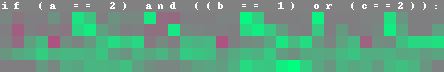

In [73]:
img = visualize_neurons(neurons, code, act)
display(img)

In [74]:
neurons

array([108,  58, 269, 279, 276])

In [79]:
act[negative, 108].sum()

0.45439816

In [81]:
x0 = 0
x1 = 0
for idx, ch in enumerate(mask):
    if ch == '_':
        x0 += act[idx, 108]
    else:
        x1 += act[idx, 108]
x0, x1

(4.2561150336332503, 0.45439814683049917)